# Task 1

In [1]:
import pandas as pd
import numpy as np
import json
import nltk
import string
from sklearn.metrics import confusion_matrix

# My custom built Naive Bayes Classifier 
from naive_bayes import NaiveBayesClassifier

# Natural Language Toolkit
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

stop_words = stopwords.words('english')
snowball_stemmer = SnowballStemmer('english')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/leon/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# Data Handling 

data = pd.read_csv('car-reviews.csv')

positive_data = data[691:]
negative_data = data[:691]

train_positive = positive_data[:553]
test_positive = positive_data[553:]

train_negative = negative_data[:553]
test_negative = negative_data[553:]

raw_training_data = pd.concat([train_positive, train_negative]).reset_index(drop=True)
raw_testing_data = pd.concat([test_positive, test_negative]).reset_index(drop=True)

raw_training_data['Sentiment'] = np.where(raw_training_data['Sentiment'] == 'Pos', 1, 0)
raw_testing_data['Sentiment'] = np.where(raw_testing_data['Sentiment'] == 'Pos', 1, 0)

In [3]:
class Processor():

    def __init__(self):
        self.sentiment_words = None 
        self.vector_sample = []
        self.stemmed_sample = []
        self.non_stemmed_sample = []

    
    def pre_processing(self, sentiment, review):
        words = review.split()
        stemmed_words = []
        stemmed_sample = {'Sentiment': sentiment,
                  'Word Table': {} }
        non_stemmed_sample = {'Sentiment': sentiment,
                              'Word Table': {} }
    
        # Loop through all words in sample 
        for word in words:

            # Remove cappital sensitivity 
            word = word.lower()

            # Removes all punctuation 
            word = ''.join(char for char in word if char not in string.punctuation)

            # Remove numbers and filter out stop words 
            if word not in stop_words:
                try:
                    int(word)
                    continue
                except:
                    pass

                try:
                    non_stemmed_sample['Word Table'][word] = non_stemmed_sample['Word Table'][word] + 1 
                except:
                    non_stemmed_sample['Word Table'][word] = 0
        
                # Applies the Snoball Stemmer from the NLTK package to the list of words in the sample 
                stemmed_word = snowball_stemmer.stem(word)
                stemmed_words.append(stemmed_word)
    
        # Create word count table of filtered stemmed words 
        for stemmed_word in stemmed_words:
            try:
                stemmed_sample['Word Table'][stemmed_word] = stemmed_sample['Word Table'][stemmed_word] + 1 
            except:
                stemmed_sample['Word Table'][stemmed_word] = 0

        self.stemmed_sample.append(stemmed_sample)
        self.non_stemmed_sample.append(non_stemmed_sample)

        return stemmed_sample



    
    def word_processing(self, training_data, testing):
        processed_samples = []
        all_words = None
    
        # Run each sample though pre-processing to filter and stem the words. Table returned
        for index, row in training_data.iterrows():
            sentiment = row['Sentiment']
            review = row['Review']
            sample = self.pre_processing(sentiment, review)
            processed_samples.append(sample)  

            # Create a sample to demonstrate the code logic in categorising and counting words per sample 
            if index in [0, (len(training_data) // 2), (len(training_data) - 1)] and not testing:
                self.vector_sample.append(training_data['Review'].iloc[index])

        # Itterate through each processed sample and add new words the all_words list 
        for idx, sample in enumerate(processed_samples):
            words = list(sample['Word Table'].keys())
            
            if idx == 0:
                all_words = words
            else:
                for word in words:
                    if word not in all_words:
                        all_words.append(word)

        return all_words, processed_samples



    
    def sentiment_filter(self, all_words):
        
        # Initialise the sentiment intensity analyser
        sia = SentimentIntensityAnalyzer()
        sentiment_words = []
        
        for word in all_words:
            # Find the sentiment intensity score of the word
            score = sia.polarity_scores(word)['compound']
            
            # Filter words based on sentiment being over or under 0. 0 being a neutral word
            if score != 0:
                sentiment_words.append(word)

        return sentiment_words

    
    
    
    def process_binary_data(self, processed_samples):
        all_data = []
        sample_data = []
        sample_count = 0

        # Convert word data to binary lists. First element is the label, the rest are the features 
        for sample in processed_samples:
            sentiment = sample['Sentiment']
            sample_data.append(sentiment)

            '''
            This logic below transforms the processed sample data into a binary format, which is vital for machine learning models to learn from.

            The sentiment of each sample is encoded at the start of its binary list (1 for 'Pos', 0 for all others), this is the label for supervised learning. 
            Then for each sample, a binary feature vector is generated. Each element in this vector signals whether a word from the list of sentiment-relevant words 
            (self.sentiment_words) is present (1) or absent (0) in the sample.

            The reason for selecting this approach is due to the consistency in feature vector length. This ensures uniformity in the length of feature vectors across 
            samples, this is vital for efficient model training and evaluation. A consistent vector size eliminates the need for adjustments based on individual sample
            content. This approach also simplifies error handling, by assigning absent words a '0' in the feature vector, the method avoids potential errors due to missing
            keys. This approach also utilises Python's handling of non-existent dictionary keys, which naturally avoids raising errors for such cases. As a result, this 
            eliminates the necessity for explicit error handling constructs like try-except blocks, reducing code complexity and improving readability. 
            This design also enhances the robustness and maintainability of the code by relying on Python's inherent features.
            '''
            
            for word in self.sentiment_words:
                if word in list(sample['Word Table'].keys()):
                    sample_data.append(1)
                else:
                    sample_data.append(0)
                    
            all_data.append(sample_data) 
            sample_data = []
    
        return np.array(all_data)


    
    
    def process(self, raw_data, testing=False):
        # Controller function that passes the raw text data to pre-processing and filters the word table for non-neutral words and outputs a binary data table for learning
        
        all_words, processed_samples = self.word_processing(raw_data, testing)

        if testing == False:
            self.sentiment_words = self.sentiment_filter(all_words)
            
        binary_data = self.process_binary_data(processed_samples)
        
        return binary_data

    
    
    def get_vector_samples(self):
        # 3 selected examples of my code outputting a word table during pre-processing 
        
        print(f'**********************  Vector Samples  **********************')
        print('\n')
        for sample in self.vector_sample:
            json_str = json.dumps(sample, indent=2)
            flattened_str = json_str.replace('\n', ' ').replace('  ', '')
            print(flattened_str)
            print('\n')


    
    def get_stemmed_samples(self):
        # 5 selected examples of my code stemming words during pre-processing 
        
        example_count = 0
        stemmed_sample_data = [{'Index': 0,
                               'Stemmed Word': 'work'},
                               {'Index': 25,
                               'Stemmed Word': 'cost'},
                               {'Index': 42,
                               'Stemmed Word': 'comfort'},
                               {'Index': 97,
                               'Stemmed Word': 'replace'},
                               {'Index': 105,
                               'Stemmed Word': 'handl'}]

        print(f'**********************  Stemmed Samples  **********************')
        print('\n')
        
        for stemmed_data in stemmed_sample_data:
        
            example_count += 1
            print(f'Stemmed Sample {example_count}')
            print('\n')
            index = stemmed_data['Index']
            word = stemmed_data['Stemmed Word']
        
            print('Training Data Index: ', index)
            print('Stemmed Word: ', word)
            print('\n')
        
            for sample in self.non_stemmed_sample[index]['Word Table']:
                if word in sample:        
                    count = self.non_stemmed_sample[index]['Word Table'][sample]
                    print('Pre-Stemmed Word: ', sample)
                    
            print('\n')
            print('Pre-Stemmed Word Table:')
            print('\n')
            print(self.non_stemmed_sample[index]['Word Table'])
            print('\n')
            print('Stemmed Word Table:')
            print('\n')
            print(self.stemmed_sample[index]['Word Table'])
            print('\n')
            print('\n')
            print('\n')

In [15]:
def process_data(processor):
    
    training_data = processor.process(raw_training_data, testing=False)
    testing_data = processor.process(raw_testing_data, testing=True)
    
    return training_data, testing_data



def custom_bayes(training_data, testing_data):
    
    naive_bayes = NaiveBayesClassifier(training_data, testing_data)
    predictions = naive_bayes.run()

    conf_matrix = confusion_matrix(testing_data[:, 0], predictions)
    conf_matrix_df = pd.DataFrame(conf_matrix, index=["Actual Negative", "Actual Positive"], columns=["Predicted Negative", "Predicted Positive"])
    display(conf_matrix_df)
    print('\n')
    
    accuracy = np.sum(predictions == testing_data[:, 0]) / len(testing_data[:, 0])
    print(f"Accuracy: {round(accuracy, 3)}")
    print('\n')

    return conf_matrix



def show_samples(processor):
    
    processor.get_vector_samples()
    processor.get_stemmed_samples()



processor = Processor()
training_data, testing_data = process_data(processor)
conf_matrix = custom_bayes(training_data, testing_data)
# show_samples(processor)

,Predicted Negative,Predicted Positive
Actual Negative,115,23
Actual Positive,47,91




Accuracy: 0.746




# Task 2 

## The Approach


I implemented a Long Short-Term Memory (LSTM) Recurrent Neural Network (RNN) to address the limitations inherent in the Bayesian model, particularly its reliance on manually extracted features like word stemming and sentiment analysis. I anticipated that a deep learning model with the innate ability to autonomously extract features from raw text would prove to be more effective. The LSTM architecture, equipped with memory cells and various gates such as input, forget, and output gates, is designed to regulate information flow, allowing the network to retain essential contextual details over lengthy text passages and to adapt dynamically to new inputs. This architectural framework enables the LSTM to learn which information is relevant over a sequence and when it can be discarded, a capability particularly useful in understanding grammatical dependencies in natural language processing.

Configuring the LSTM RNN model required deliberate architectural choices, including the number of layers, dropout rates, and types of word embeddings used, to optimise the model's performance for our specific NLP task. I aimed to achieve an enhanced understanding of textual context and sentiment and a level of feature learning sophistication that was not possible with the Bayesian approach. 

I opted for a bi-directional LSTM model, which can capture patterns from both past and future contexts, despite doubling the number of parameters and adding complexity. The deep learning model I implemented consisted of an input layer, an embedding layer, a bi-directional LSTM layer, and an output layer. To combat overfitting, dropout was applied to the LSTM layer, and regularization was added to the output layer, measures intended to ensure the model's ability to generalise well to new, unseen data.

The selection of the Adam optimizer, sigmoid activation function, and binary crossentropy loss function for an LSTM model is strategic for binary classification tasks. Adam is chosen for its ability to handle large datasets and complex landscapes through automatic learning rate adjustments and efficient convergence. The sigmoid function is ideal for binary outcomes as it outputs probabilities between 0 and 1, providing a clear decision boundary. Lastly, binary crossentropy effectively measures prediction accuracy, penalizing incorrect predictions significantly, and thus driving the model towards more precise classifications. Together, these choices optimize the model for better performance in binary classification by ensuring fast, accurate, and efficient learning.

* https://en.wikipedia.org/wiki/Long_short-term_memory
* Russel / Norvig - Artifical Intelligence – A Modern Approach – 4th edition – Chapter 22.6.2  
* Russel / Norvig - Artifical Intelligence – A Modern Approach – 4th edition – Chapter 25.2.3  
* https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17
* https://www.embedded-robotics.com/sentiment-analysis-using-lstm/
* https://www.analyticsvidhya.com/blog/2021/06/natural-language-processing-sentiment-analysis-using-lstm/
* https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/
    

In [16]:
# Visualisation 
import matplotlib.pyplot as plt  
import seaborn as sns  
from sklearn.metrics import accuracy_score, confusion_matrix

# Keras for deep learning models
from tensorflow.keras.preprocessing.text import Tokenizer  # For tokenising text data
from tensorflow.keras.preprocessing.sequence import pad_sequences  # For sequence padding to uniform length
from tensorflow.keras.models import Sequential  # For sequential model architecture
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Bidirectional, Dropout  # Layers for model building
from tensorflow.keras.regularizers import l2  # L2 regularisation to prevent overfitting
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, History
from tensorflow.keras.optimizers import Adam

In [17]:
def prepare_data():
    
    # Load the dataset from a CSV file
    data = pd.read_csv('car-reviews.csv')
    
    # Splitting the data into positive and negative reviews based on a predetermined index
    positive_data = data[691:]  
    negative_data = data[:691]  
    
    # Further split positive and negative datasets into training and testing subsets
    train_positive = positive_data[:553]
    test_positive = positive_data[553:] 
    train_negative = negative_data[:553]
    test_negative = negative_data[553:]  
    
    # Concatenate the positive and negative training data, and do the same for testing data
    training_data = pd.concat([train_positive, train_negative]).reset_index(drop=True)
    testing_data = pd.concat([test_positive, test_negative]).reset_index(drop=True)
    
    # Convert the 'Sentiment' column into a binary format: 1 for positive, 0 for negative
    training_data['Sentiment'] = np.where(training_data['Sentiment'] == 'Pos', 1, 0)
    testing_data['Sentiment'] = np.where(testing_data['Sentiment'] == 'Pos', 1, 0)

    # Extract reviews (as text) and their corresponding labels for training and testing
    training_texts = list(training_data['Review'])
    training_labels = list(training_data['Sentiment'])
    test_texts = list(testing_data['Review'])
    test_labels = list(testing_data['Sentiment'])

    # Return the processed text and labels for training and testing
    return list((training_texts, training_labels, test_texts, test_labels))

In [18]:
class LSTM_Classifier():

    model = None
    history = None
    file_id = None
    conf_matrix = None

    def __init__(self, data, embedding_output_dim, lstm_unit, dropout_rate, reg_strength, epochs, batch_size):

        self.data = data
        self.embedding_output_dim = embedding_output_dim
        self.lstm_unit = lstm_unit
        self.dropout_rate = dropout_rate
        self.reg_strength = reg_strength
        self.epochs = epochs
        self.batch_size = batch_size

    

    
    def tokenisation(self):
        
        # Initialise the tokenizer with a maximum number of words to keep, based on word frequency
        tokenizer = Tokenizer(num_words=10000)  # Setting the size of the vocabulary to the top 10,000 words
        tokenizer.fit_on_texts(self.data[0])  # Updates internal vocabulary based on the list of texts
        
        # Convert the list of texts to a sequence of integers
        train_sequences = tokenizer.texts_to_sequences(self.data[0])  # Transforms each text in training_texts to a sequence of integers
        self.data[0] = pad_sequences(train_sequences, maxlen=100)  # Ensures all sequences in a list have the same length by padding/truncating
        self.data[1] = np.array(self.data[1])  
        
        # Repeat the tokenisation and padding process for the testing set
        test_sequences = tokenizer.texts_to_sequences(self.data[2]) 
        self.data[2] = pad_sequences(test_sequences, maxlen=100) 
        self.data[3] = np.array(self.data[3])  

    
    

    def build_model(self):

        """
        Parameters:
            - embedding_dim: Dimension of the embedding layer
            - lstm_unit: Number of units in the LSTM layer
            - dropout_rate: Dropout rate for regularization
            - reg_strength: Strength of L2 regularization
        """
    
        self.model = Sequential([
            
            # Input layer specifies the shape of input data = pad_sequences_maxlen
            Input(shape=(100,)),
            
            # Embedding layer to turn positive integers (indexes) into dense vectors of fixed size, 10000 is the size of the vocabulary
            Embedding(input_dim=10000, output_dim=self.embedding_output_dim),
            
            # LSTM layer with specified units and dropout for regularization
            # Wrap the LSTM layer with a Bidirectional layer
            Bidirectional(LSTM(self.lstm_unit, dropout=self.dropout_rate, recurrent_dropout=self.dropout_rate)),
            
            # Dense output layer with sigmoid activation for binary classification
            Dense(1, activation='sigmoid', kernel_regularizer=l2(self.reg_strength))
        ])


    

    def train_model(self):

        # Compile models with selected optimisation parameters
        self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        
        # Train the model on the training data, with a validation split to monitor overfitting added early stopping with a patience of 3
        self.history = self.model.fit(self.data[0], self.data[1], batch_size=self.batch_size, epochs=self.epochs, validation_split=0.2, callbacks=EarlyStopping(patience=3))

 


    
    def evaluate_model(self):

        # Predict probabilities on the test set and convert to class labels (1 or 0) based on a 0.5 threshold
        test_probabilities = self.model.predict(self.data[2])
        test_predictions = (test_probabilities > 0.5).astype("int32").flatten()
        
        # Generating the confusion matrix from test labels and predictions
        self.conf_matrix = confusion_matrix(self.data[3], test_predictions)
        conf_matrix_df = pd.DataFrame(self.conf_matrix, index=["Actual Negative", "Actual Positive"], columns=["Predicted Negative", "Predicted Positive"])
        print('\n')
        display(conf_matrix_df)
    
        accuracy = accuracy_score(self.data[3], test_predictions)
        print('\n')
        print('Accuracy: ', round(accuracy, 3))
        print('\n')
    
        # Call the model evaluation function to plot training history
        self.visualise_accuracy()


    

    def visualise_accuracy(self):

        training_accuracy = self.history.history['accuracy']
        validation_accuracy = self.history.history['val_accuracy']
        training_loss = self.history.history['loss']
        validation_loss = self.history.history['val_loss']
        epochs = range(1, len(training_accuracy) + 1)

        with plt.style.context('dark_background'):
            
            plt.figure(figsize=(10, 4))
            
            # Plotting training and validation accuracy
            plt.subplot(1, 2, 1)
            plt.plot(epochs, training_accuracy, label='Training Accuracy', marker='o', color='lime')
            plt.plot(epochs, validation_accuracy, label='Validation Accuracy', marker='o', color='cyan')
            plt.title('Training and Validation Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.legend()
            
            # Plotting training and validation loss
            plt.subplot(1, 2, 2)
            plt.plot(epochs, training_loss, label='Training Loss', marker='o', color='lime')
            plt.plot(epochs, validation_loss, label='Validation Loss', marker='o', color='cyan')
            plt.title('Training and Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            
            plt.tight_layout()
            plt.show()


    
    def run(self, file_id = None):
        self.file_id = file_id
        self.tokenisation()
        self.build_model()
        self.train_model()
        self.evaluate_model()


Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.6178 - loss: 0.6774 - val_accuracy: 0.0000e+00 - val_loss: 0.9415
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.6538 - loss: 0.6019 - val_accuracy: 0.2117 - val_loss: 1.0998
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8675 - loss: 0.3800 - val_accuracy: 0.3153 - val_loss: 1.3493
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9580 - loss: 0.1700 - val_accuracy: 0.5270 - val_loss: 0.9856
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step




,Predicted Negative,Predicted Positive
Actual Negative,68,70
Actual Positive,21,117




Accuracy:  0.67




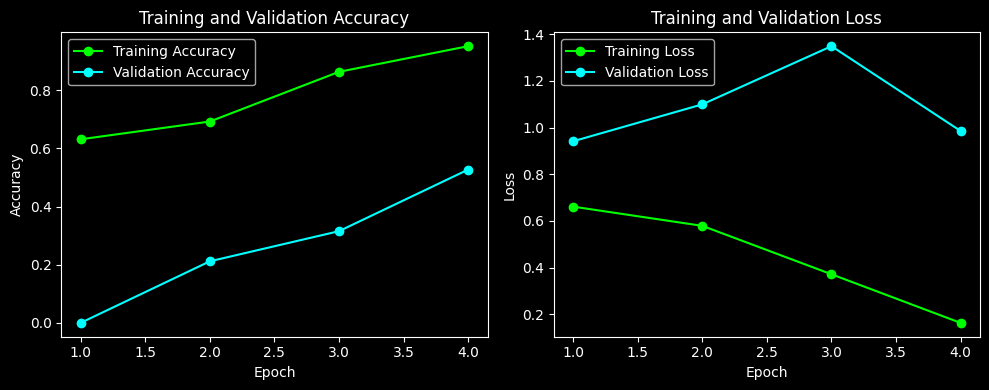

In [19]:
data = prepare_data()

# Selected hyperparameters for my LSTM model 
lstm_classifier = LSTM_Classifier(data, embedding_output_dim = 128, lstm_unit = 64, dropout_rate = 0.05, reg_strength = 0.0, epochs = 10, batch_size = 32)
lstm_classifier.run()

## Evaluation



,Accuracy,Precision,Recall,F1 Score
Bayes,0.746,0.798,0.659,0.722
LSTM,0.670,0.626,0.848,0.720


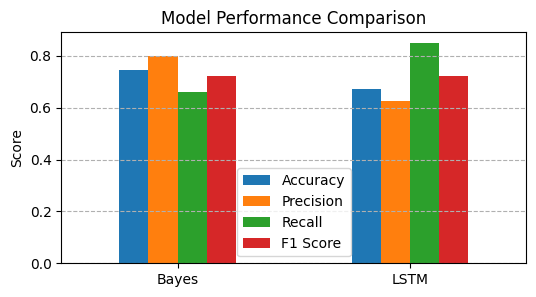



LSTM Model Paramters:




Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,136,837 (15.78 MB)

 Trainable params: 1,378,945 (5.26 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,757,892 (10.52 MB)

In [27]:
def calculate_performance_metrics(conf_matrix):

    # Get True Positive, True Negative, False Positive, False Negative 
    TN = conf_matrix[0][0]
    TP = conf_matrix[1][1]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]

    # Calculate accuracy, precision, recall, f1_score
    accuracy = (TP + TN) / (TP + FP + FN + TN)
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    
    return round(accuracy, 3), round(precision, 3), round(recall, 3), round(f1_score, 3)


# Compare LSTM and Bayes Conf matricies
metrics_1 = calculate_performance_metrics(conf_matrix_1)
metrics_2 = calculate_performance_metrics(lstm_classifier.conf_matrix)

metrics_df = pd.DataFrame([metrics_1, metrics_2], 
                          index=['Bayes', 'LSTM'], 
                          columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'])


# Display accuracy, precision, recall, f1_score table and graph comparison and display LSTM models parameters.
print('\n')
display(metrics_df)
print('\n')
metrics_df.plot(kind='bar', figsize=(6, 3))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.show()
print('\n')
print('LSTM Model Paramters:')
print('\n')
lstm_classifier.model.summary()
print('\n')

### Model Comparison 

- **Bayes Model** achieves higher accuracy (0.746) and precision (0.798) than the LSTM model, indicating it makes fewer mistakes overall and is more reliable in its positive predictions. However, its lower recall (0.659) suggests it misses more positive instances than the LSTM model.

- **LSTM Model** stands out for its significantly higher recall (0.870), showing a superior ability to identify all positive instances, despite having lower accuracy (0.641) and precision (0.597). The F1 Score of the LSTM model (0.708) is slightly lower than the Bayes model (0.722), indicating a close but slightly less balanced performance between precision and recall.

The performance of my LSTM model did not meet the expectations I had set, despite careful consideration and adjustment of hyperparameters. Rather than making arbitrary selections, I engaged in a thorough process of experimentation and optimisation, initially applying a grid search technique followed by leveraging the Optuna package for a more refined search in high-dimensional space. Despite these efforts to fine-tune the model, there was minimal improvement in accuracy observed.

One explination for this may be that my LSTM model is far more complex, with infact 4,136,837 parameters. If the dataset is not large enough, this complexity can lead to overfitting, where the model learns noise in the training data instead of the underlying pattern. In contrast, simpler models like Naive Bayes might perform better because they have fewer parameters and are less likely to overfit on small datasets

Another explination may be due to the fact that the dataset of only 1382 to work with - LSTM despite their ability to understand sequence and context, may require more data to achieve a similar level of understanding and effectiveness in utilizing contextual information

In summary, while LSTM models have the theoretical capability to outperform simpler models like Naive Bayes by leveraging sequence information and context, practical considerations such as data size, model complexity, training procedures, has lead to the theory not playing out in practice.